# Using Binary Classification Model to Predict Permit Status of Seattle Special Event  (Completed vs. Others) 

## 1. Upload and Clean datasets

------
 - In this exercise, different types of binary classification models will be explored to predict permit status of special events held in Seattle. This Binary classification ML exercise is inspired by the PyData video [1].
 - Dataset for this model building and validation is obtained from the state official open data [2].
 - Ultimate model objective is to predict permit status into 2 categories: __complete vs. not__ (can be 'In Process', 'On Hold', 'Cancelled', 'Issued'). Hence PermitStatus column in the dataset will be converted into binary values with __1 for complete__ and __0 for others__. 



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler, minmax_scale

from imblearn import under_sampling, over_sampling

ranstate = 4321
path = 'D:\\Programing\\GithubDataset\\Seattle\\'
file = path + 'Special_Events_Permits.csv' 
df1 = pd.read_csv(file)
df1.head()

,Application Date,Permit Status,Permit Type,Event Category,Event Sub-Category,Name of Event,Year-Month-App#,Event Start Date,Event End Date,Event Location - Park,Event Location - Neighborhood,Council District,Precinct,Organization,Attendance
0,12/13/2022 12:00:00 AM,In Process,Special Event,Athletic,Run/Walk,Alki Beach Sunset Run,S22AU014,08/20/2022 12:00:00 AM,08/20/2022 12:00:00 AM,Alki Beach,Alki / Admiral,1,"Southwest, Traffic",Fizz Events,1050.0
1,07/21/2021 12:00:00 AM,In Process,Special Event,Commercial,NaN,Capitol Hill Block Party,S22JY002,07/22/2022 12:00:00 AM,07/24/2022 12:00:00 AM,Cal Anderson Park,Capitol Hill,3,"East, Operations",Independent Event Solutions,27900.0
2,01/07/2022 12:00:00 AM,In Process,Special Event,Athletic,Run/Walk,Rivkin Summer Run,S22JY026,07/17/2022 12:00:00 AM,07/17/2022 12:00:00 AM,Seward Park,Seward Park,2,South,Rivkin Center,1350.0
3,01/10/2022 12:00:00 AM,In Process,Special Event,Athletic,Water,Fat Salmon Open Water Swim,S22JY028,07/16/2022 12:00:00 AM,07/16/2022 12:00:00 AM,Madison Park,Madison Park,3,"East, Harbor",Orca Swim Team,450.0
4,11/04/2021 12:00:00 AM,In Process,Special Event,Athletic,Cycling,Seattle to Portland Bicycle Classic,S22JY006,07/16/2022 12:00:00 AM,07/16/2022 12:00:00 AM,NaN,"Columbia City, Madison Park, Madrona / Leschi,...","2, 3, 4","East, North, South, Traffic",Cascade Bicycle Club,6100.0


In [2]:
# rename column names by removing spaces and special characters from original column names
col = list(df1.columns)
#import re
#col = [re.sub('[^A-Za-z0-9#]+','', i) for i in col]

col = [i.replace(" ", "") for i in col]
col = [i.replace('-', '') for i in col]
col = [i.replace('#', '').lower() for i in col]
#print(col)

keys = list(df1.columns)
coldict = dict(zip(keys,col))
#print(coldict)

df1.rename(columns=coldict, inplace=True)
print(df1.columns)

Index(['applicationdate', 'permitstatus', 'permittype', 'eventcategory',
       'eventsubcategory', 'nameofevent', 'yearmonthapp', 'eventstartdate',
       'eventenddate', 'eventlocationpark', 'eventlocationneighborhood',
       'councildistrict', 'precinct', 'organization', 'attendance'],
      dtype='object')


In [3]:
df1.head()

,applicationdate,permitstatus,permittype,eventcategory,eventsubcategory,nameofevent,yearmonthapp,eventstartdate,eventenddate,eventlocationpark,eventlocationneighborhood,councildistrict,precinct,organization,attendance
0,12/13/2022 12:00:00 AM,In Process,Special Event,Athletic,Run/Walk,Alki Beach Sunset Run,S22AU014,08/20/2022 12:00:00 AM,08/20/2022 12:00:00 AM,Alki Beach,Alki / Admiral,1,"Southwest, Traffic",Fizz Events,1050.0
1,07/21/2021 12:00:00 AM,In Process,Special Event,Commercial,NaN,Capitol Hill Block Party,S22JY002,07/22/2022 12:00:00 AM,07/24/2022 12:00:00 AM,Cal Anderson Park,Capitol Hill,3,"East, Operations",Independent Event Solutions,27900.0
2,01/07/2022 12:00:00 AM,In Process,Special Event,Athletic,Run/Walk,Rivkin Summer Run,S22JY026,07/17/2022 12:00:00 AM,07/17/2022 12:00:00 AM,Seward Park,Seward Park,2,South,Rivkin Center,1350.0
3,01/10/2022 12:00:00 AM,In Process,Special Event,Athletic,Water,Fat Salmon Open Water Swim,S22JY028,07/16/2022 12:00:00 AM,07/16/2022 12:00:00 AM,Madison Park,Madison Park,3,"East, Harbor",Orca Swim Team,450.0
4,11/04/2021 12:00:00 AM,In Process,Special Event,Athletic,Cycling,Seattle to Portland Bicycle Classic,S22JY006,07/16/2022 12:00:00 AM,07/16/2022 12:00:00 AM,NaN,"Columbia City, Madison Park, Madrona / Leschi,...","2, 3, 4","East, North, South, Traffic",Cascade Bicycle Club,6100.0


In [4]:
df1.permitstatus.unique()

array(['In Process', 'On Hold', 'Cancelled', 'Complete', 'Issued'],
      dtype=object)

In [5]:
df1.permitstatus.isna().sum()

0

In [6]:
# check if distribution of outcome is balanced.
df1.groupby('permitstatus').size()  

permitstatus
Cancelled      472
Complete      3016
In Process      26
Issued          36
On Hold         20
dtype: int64

In [7]:
df = df1.fillna(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3570 entries, 0 to 3569
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   applicationdate            3570 non-null   object 
 1   permitstatus               3570 non-null   object 
 2   permittype                 3570 non-null   object 
 3   eventcategory              3570 non-null   object 
 4   eventsubcategory           3570 non-null   object 
 5   nameofevent                3570 non-null   object 
 6   yearmonthapp               3570 non-null   object 
 7   eventstartdate             3570 non-null   object 
 8   eventenddate               3570 non-null   object 
 9   eventlocationpark          3570 non-null   object 
 10  eventlocationneighborhood  3570 non-null   object 
 11  councildistrict            3570 non-null   object 
 12  precinct                   3570 non-null   object 
 13  organization               3570 non-null   objec

In [8]:
3016/3570
# ~85% of outcome is complete (positive class). ==> considered imbalance. 

0.8448179271708683

In [9]:
# convert complete into 1 and others into 0 for binary classification outcome/target.
df.permitstatus = np.where(df.permitstatus == 'Complete', 1, 0)

In [10]:
df.sample(10) #--> majority is category 1

,applicationdate,permitstatus,permittype,eventcategory,eventsubcategory,nameofevent,yearmonthapp,eventstartdate,eventenddate,eventlocationpark,eventlocationneighborhood,councildistrict,precinct,organization,attendance
1435,12/15/2017 12:00:00 AM,1,Special Event,Free Speech,0,"Martin Luther King, Jr Celebration",S18JA039,01/15/2018 12:00:00 AM,01/15/2018 12:00:00 AM,0,"First Hill, Downtown","3, 7","East, West",MLK Celebration Committee,5100.0
3523,0,1,Valet Parking,0,0,Teatro Zinzanni,S14FE111,02/22/2014 12:00:00 AM,02/22/2014 12:00:00 AM,0,Queen Anne,0,0,Red Carpet Valet,200.0
737,03/08/2019 12:00:00 AM,1,Special Event,Commercial,0,Wildrose Pride 2019,S19JU194,06/28/2019 12:00:00 AM,06/30/2019 12:00:00 AM,0,Capitol Hill,3,"East, Operations",Wildrose,7190.0
2579,0,0,Valet Parking,0,0,Red Carpet Valet - 415 Westlake,S15DE522,12/12/2015 12:00:00 AM,12/12/2015 12:00:00 AM,0,Downtown,7,West,Red Carpet Valet,90.0
2431,05/06/2016 12:00:00 AM,1,Special Event,Free Speech,0,Democracy Spring Across America!,S16MY287,05/14/2016 12:00:00 AM,05/14/2016 12:00:00 AM,0,Pioneer Square,7,South,Democracy Spring Across America,110.0
1505,08/30/2017 12:00:00 AM,1,Special Event,Community,0,UW Husky Marching Band Rally (11.17),S17NO495,11/17/2017 12:00:00 AM,11/17/2017 12:00:00 AM,0,University District,4,North,Husky Marching Band,1000.0
3188,0,1,Special Event,Commercial,0,Belltown Crush,S14SE376,09/28/2014 12:00:00 AM,09/28/2014 12:00:00 AM,Bell Street Park,Belltown,0,0,University District Food Bank,330.0
1634,03/15/2017 12:00:00 AM,1,Special Event,Community,0,Sounders FC March to the Match (8.27),S17AU310,08/27/2017 12:00:00 AM,08/27/2017 12:00:00 AM,Occidental Park,Pioneer Square,3,West,Sounders FC,500.0
1490,11/07/2017 12:00:00 AM,1,Special Event,Community,0,Sounders FC March to the Match (11.30),S17NO558,11/30/2017 12:00:00 AM,11/30/2017 12:00:00 AM,Occidental Park,Pioneer Square,3,West,Sounders FC,500.0
3079,0,1,Special Event,Commercial,0,Seattle Boat Show on South Lake Union,S15JA016,01/23/2015 12:00:00 AM,02/01/2015 12:00:00 AM,Lake Union Park,Cascade / Eastlake / South Lake Union,7,West,NW Yacht Brokers Association,12500.0


## 2. Pre-Processing Dataset

### 2.1. Convert string timestamp columns into datetime obj and calculate time difference to store as numeric float

In [11]:
import datetime as dt
df.applicationdate = df.applicationdate.astype('datetime64')
df.eventstartdate = df.eventstartdate.astype('datetime64')
df.eventenddate = df.eventenddate.astype('datetime64')
df.head()

,applicationdate,permitstatus,permittype,eventcategory,eventsubcategory,nameofevent,yearmonthapp,eventstartdate,eventenddate,eventlocationpark,eventlocationneighborhood,councildistrict,precinct,organization,attendance
0,2022-12-13,0,Special Event,Athletic,Run/Walk,Alki Beach Sunset Run,S22AU014,2022-08-20,2022-08-20,Alki Beach,Alki / Admiral,1,"Southwest, Traffic",Fizz Events,1050.0
1,2021-07-21,0,Special Event,Commercial,0,Capitol Hill Block Party,S22JY002,2022-07-22,2022-07-24,Cal Anderson Park,Capitol Hill,3,"East, Operations",Independent Event Solutions,27900.0
2,2022-01-07,0,Special Event,Athletic,Run/Walk,Rivkin Summer Run,S22JY026,2022-07-17,2022-07-17,Seward Park,Seward Park,2,South,Rivkin Center,1350.0
3,2022-01-10,0,Special Event,Athletic,Water,Fat Salmon Open Water Swim,S22JY028,2022-07-16,2022-07-16,Madison Park,Madison Park,3,"East, Harbor",Orca Swim Team,450.0
4,2021-11-04,0,Special Event,Athletic,Cycling,Seattle to Portland Bicycle Classic,S22JY006,2022-07-16,2022-07-16,0,"Columbia City, Madison Park, Madrona / Leschi,...","2, 3, 4","East, North, South, Traffic",Cascade Bicycle Club,6100.0


In [12]:
df['apptostart'] = (df.eventstartdate - df.applicationdate).dt.days.astype(int)
df['apptoend'] = (df.eventenddate - df.applicationdate).dt.days.astype(int)
df['starttoend'] = (df.eventenddate - df.eventstartdate).dt.days.astype(int)

df.info(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3570 entries, 0 to 3569
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   applicationdate            3570 non-null   datetime64[ns]
 1   permitstatus               3570 non-null   int32         
 2   permittype                 3570 non-null   object        
 3   eventcategory              3570 non-null   object        
 4   eventsubcategory           3570 non-null   object        
 5   nameofevent                3570 non-null   object        
 6   yearmonthapp               3570 non-null   object        
 7   eventstartdate             3570 non-null   datetime64[ns]
 8   eventenddate               3570 non-null   datetime64[ns]
 9   eventlocationpark          3570 non-null   object        
 10  eventlocationneighborhood  3570 non-null   object        
 11  councildistrict            3570 non-null   object        
 12  precin

## 2.2. Drop columns that would not be useful for training model

In [13]:
# drop irrelevant/useless columns from df
df = df.drop(['applicationdate','nameofevent','yearmonthapp', 'eventstartdate',
       'eventenddate','eventsubcategory','organization'], axis=1)
col_names= list(df.columns)
print(col_names)
#df.loc[50:70]

['permitstatus', 'permittype', 'eventcategory', 'eventlocationpark', 'eventlocationneighborhood', 'councildistrict', 'precinct', 'attendance', 'apptostart', 'apptoend', 'starttoend']


## 2.3. Process data column-wise to standardized format for analysis

In [14]:
# create function to return a list containing unique values within a df column
def uniqval(dfcol):
    a = list(dfcol.unique())
    b = len(list(dfcol.unique()))
    return (a, b)

In [15]:
# get unique values of each columns to define new features for training
c1 = uniqval(df.permittype)
c2 = uniqval(df.eventcategory)
c3 = uniqval(df.eventlocationpark)
c4 = uniqval(df.eventlocationneighborhood)
c5 = uniqval(df.councildistrict)
c6 = uniqval(df.precinct)
c7 = uniqval(df.starttoend)
c8 = uniqval(df.apptostart)
c9 = uniqval(df.apptoend)

#### 2.3.1. c1 and c2 contains categories within reasonable variations --> will be onehot-encoded.

In [16]:
print(c1, '\n', c2)

(['Special Event', 'Valet Parking', 'Charter Vessel'], 3) 
 (['Athletic', 'Commercial', 'Community', 'Free Speech', 0, 'Citywide', 'Mixed Free Speech'], 7)


In [17]:
def onehot_encode(df, col, prefix):
    df = df.copy()
    dummies = pd.get_dummies(df[col],prefix=prefix)
    df = pd.concat([df,dummies], axis=1)
    df = df.drop(col, axis=1)
    return df

In [18]:
df = onehot_encode(df,'permittype','PT')

In [19]:
#df = df.drop('eventcategory', axis=1) # try droping eventcategory since ~16% of data in this col are populated with fillna(0)
df = onehot_encode(df,'eventcategory','EC')

#### 2.3.2. c5 contains single numeric value and string representation of multiple numeric values in the form of list; hence, entries with numeric list will be lumped as a sum of the numbers inside the list

In [20]:
print(c5, '\n')
print(type(c5[0][3]))

(['1', '3', '2', '2, 3, 4', '4', '6', '7', '3, 4, 7', '4, 6, 7', '2, 3, 7', '5', '4, 5, 6', '3, 4', '3, 7', '3, 4, 6, 7', '4, 7', 0, '2, 3', '4, 5', '6, 7', '4, 6', '2, 7', '2, 3, 4, 7', '1, 3, 5', '3, 4, 5, 6, 7', '3, 6', '1, 2, 3, 7', '1, 2, 3, 4, 6, 7', '1, 2, 3, 4, 5, 6, 7', '3, 4, 6', '1, 2', '1, 2, 6'], 32) 

<class 'str'>


In [21]:
# test for c5, lump entries with multiple CountryDistrict into a single summed value representation.
j =[]
for i in c5[0]:
    if type(i) == int:
        j.append(i)
    else:
        j.append(np.fromstring(i, dtype=int, sep=', ').sum())
print('test approach: ', j, '\n')

# use similar approach in a function that takes in df.councildistrict col and return a representative integer value of each row
def repr_int(df):
    j =[]
    for i in df:
        if type(i) == int:
            j.append(i)
        else:
            j.append(np.fromstring(i, dtype=int, sep=',').sum())
    return pd.Series(j)

print(repr_int(df.councildistrict))

test approach:  [1, 3, 2, 9, 4, 6, 7, 14, 17, 12, 5, 15, 7, 10, 20, 11, 0, 5, 9, 13, 10, 9, 16, 9, 25, 9, 13, 23, 28, 13, 3, 9] 

0       1
1       3
2       2
3       3
4       9
       ..
3565    0
3566    0
3567    0
3568    0
3569    0
Length: 3570, dtype: int64


In [22]:
df.councildistrict = repr_int(df.councildistrict)

#### 2.3.3. c8 and c9 are both related to time difference between permit application date, event start date and event end date, within similar scales. Hence, these columns will be lumped as ratio c8/c9 (taking difference will result in column c7).

In [23]:
df['ratio'] = df.apptostart/df.apptoend

# check for NaN in case of division by zero
if df.ratio.isna().sum() != 0:
    print('probable number of division by zero case: ', df.ratio.isna().sum())
    df.ratio = df.ratio.fillna(0)
    print(df.ratio.isna().sum())

probable number of division by zero case:  5
0


#### 2.3.4. To prevent overtraining, c3, c4, and c6 will be dropped since these features contain highly-sparsed categories (>20-30 unique values in each cols);  c7 will be used as is, but scaled using minmax_scaler.

In [24]:
X = df.drop(['eventlocationpark', 'eventlocationneighborhood', 'precinct', 'apptostart','apptoend'], axis=1)
X.attendance = minmax_scale(X.attendance)
X.councildistrict = minmax_scale(X.councildistrict)
X.starttoend = minmax_scale(X.starttoend)
X.head(10)


,permitstatus,councildistrict,attendance,starttoend,PT_Charter Vessel,PT_Special Event,PT_Valet Parking,EC_0,EC_Athletic,EC_Citywide,EC_Commercial,EC_Community,EC_Free Speech,EC_Mixed Free Speech,ratio
0,0,0.035714,0.002979,0.000000,0,1,0,0,1,0,0,0,0,0,1.000000
1,0,0.107143,0.079149,0.005464,0,1,0,0,0,0,1,0,0,0,0.994565
2,0,0.071429,0.003830,0.000000,0,1,0,0,1,0,0,0,0,0,1.000000
3,0,0.107143,0.001277,0.000000,0,1,0,0,1,0,0,0,0,0,1.000000
4,0,0.321429,0.017305,0.000000,0,1,0,0,1,0,0,0,0,0,1.000000
5,0,0.142857,0.020440,0.002732,0,1,0,0,0,0,1,0,0,0,0.992958
6,0,0.214286,0.014326,0.000000,0,1,0,0,0,0,0,1,0,0,1.000000
7,0,0.250000,0.001277,0.000000,0,1,0,0,0,0,1,0,0,0,1.000000
8,0,0.107143,0.001064,0.000000,0,1,0,0,0,0,0,1,0,0,1.000000
9,0,0.107143,0.008511,0.000000,0,1,0,0,1,0,0,0,0,0,1.000000


In [25]:
print(X.columns)

Index(['permitstatus', 'councildistrict', 'attendance', 'starttoend',
       'PT_Charter Vessel', 'PT_Special Event', 'PT_Valet Parking', 'EC_0',
       'EC_Athletic', 'EC_Citywide', 'EC_Commercial', 'EC_Community',
       'EC_Free Speech', 'EC_Mixed Free Speech', 'ratio'],
      dtype='object')


## 3. Exploratory Data Analysis (EDA)

### 3.1. Explore if there is any plaussible strong predictior of the permitstatus outcome from feature column(s).

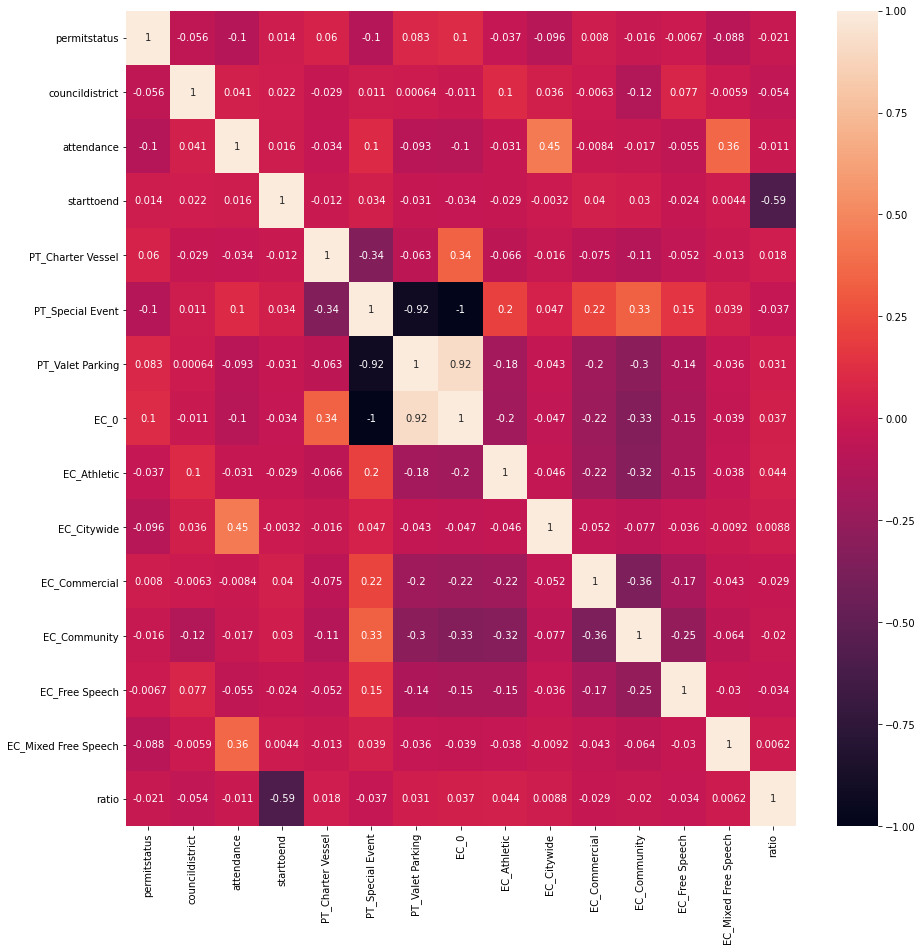

In [26]:
corr_matrix = X.corr()  # --> predictors are generally weak for the status, quite expected?? 

plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix, annot=True, vmin=-1.0, vmax=1.0)
plt.show()

### 3.2. Plot box plot to check the spread of the distributions for the binary feature columns

<AxesSubplot:>

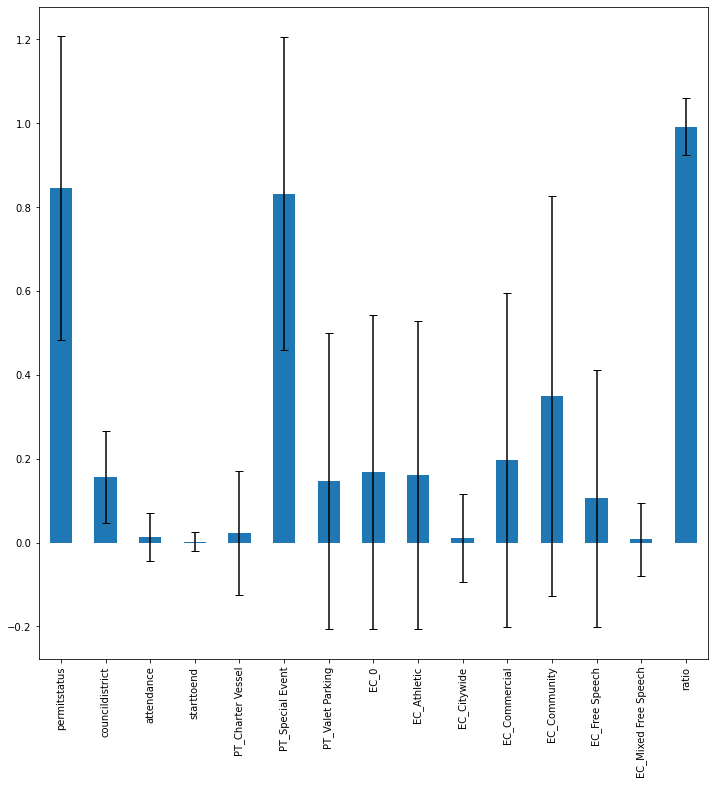

In [27]:
error = X.std()
X.mean().plot.bar(yerr=error, capsize=4, figsize=(12,12))

# barplot of the mean values of binary feature columns (contain only values of 0 or 1) implies how equally distributed
      # these values are within each feature columns.
      # mean >>> 0.5 implies more 1 values for that particular feature. 
      # keep in mind that some features (like EventCategory) contain considerable NaN values and pre-populated with 0.
      # hence, feature column with 'EC' prefix are mostly skewed towards 0 value. --> can compare model with and without EC feature.


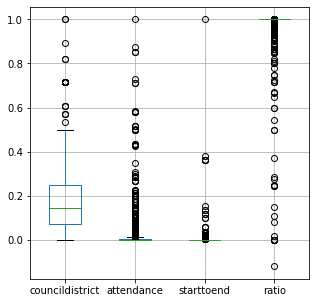

In [28]:
boxplot = X.boxplot(column=['councildistrict','attendance','starttoend','ratio'], figsize=(5,5))

### 3.3. Create feature matrix X and target vector y, then split into train & test datasets

In [29]:
y = X.permitstatus
X = X.drop('permitstatus', axis=1)

In [30]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42, shuffle=True)

In [32]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2499, 14)
(2499,)
(1071, 14)
(1071,)


## 4. Exploring Different Binary Classification Models

### First, import the required classification models and define a function to plot the classification metrics

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


def plot_clf_metrics(y_true, y_pred, y_proba, labels=['Neg Category','Pos Category']):
    
    # confusion matrix calc
    cm = confusion_matrix(y_true, y_pred)

    # ROC curve calc
    fpr, tpr, _ = roc_curve(y_true, y_proba)

    # Precision Recall curve calc
    prec, recl, treshold = precision_recall_curve(y_true, y_proba)

    # Plot figure and subplots
    fig = plt.figure(figsize=[12,4])

    gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0.05, right=0.35, wspace=0.05)    
    ax1 = fig.add_subplot(gs1[0, 0])
    sns.heatmap(cm, annot=True, fmt='g', ax=ax1)#, yticklabels=labels, xticklabels=labels)
    ax1.set_xlabel('Predicted labels');ax1.set_ylabel('True labels'); 
    ax1.set_title('Confusion Matrix')
    ax1.xaxis.set_ticklabels(labels, ha='center') 
    ax1.yaxis.set_ticklabels(labels, ha='center', rotation=90, rotation_mode='anchor')
    
    gs2 = fig.add_gridspec(nrows=1, ncols=1, left=0.45, right=0.7, wspace=0.1)
    ax2 = fig.add_subplot(gs2[0, 0])
    ax2.plot(fpr,tpr, color = 'b', label="AUC={:.3f}".format(roc_auc_score(y_true, y_proba)) )
    ax2.plot([0, 1], [0, 1], color = 'g', linestyle='--')
    ax2.set_title('ROC Curve')
    ax2.set_xlabel('False Positive Rate'); ax2.set_ylabel('True Positive Rate')
    ax2.set_xlim([-0.05,1.05]); ax2.set_ylim([-0.05,1.05])
    ax2.legend(prop={'size':12}, loc='lower right')

    gs3 = fig.add_gridspec(nrows=1, ncols=1, left=0.8, right=1.05, wspace=0.15)
    ax3 = fig.add_subplot(gs3[0, 0])
    ax3.plot(recl,prec,  color = 'b', label="Avg Prec Score={:.3f}".format(average_precision_score(y_true, y_pred)) )
    ax3.set_title('Precision Recall Curve')
    ax3.set_xlabel('Recall'); ax3.set_ylabel('Precision')
    ax3.set_xlim([-0.05,1.05]); ax3.set_ylim([-0.05,1.05])
    ax3.legend(prop={'size':12}, loc='lower left')

    plt.show()

### 4.1. RandomForestClassifier Model

In [34]:
# instantiate initial RFC
em = RandomForestClassifier(n_estimators=100, random_state=ranstate, class_weight=None)  #['balanced','balanced_subsample',None] def is none

# optimized with GS:
#em = RandomForestClassifier(class_weight='balanced',criterion='gini',max_features=6,n_estimators=200)

# fit training dataset
em.fit(X_train, y_train)

# calc model prediction and probability that model predicts a positive label given an X in X_test
y_pred1 = em.predict(X_test)
y_proba1 = em.predict_proba(X_test)

# cross validate model with test dataset
em.score(X_test, y_test)  # equiv to np.mean(y_pred1 == y_test) or accuracy_score(y_pred1 == y_test), 
                          #   not a very robust metrics for imbalanced dataset

0.8104575163398693

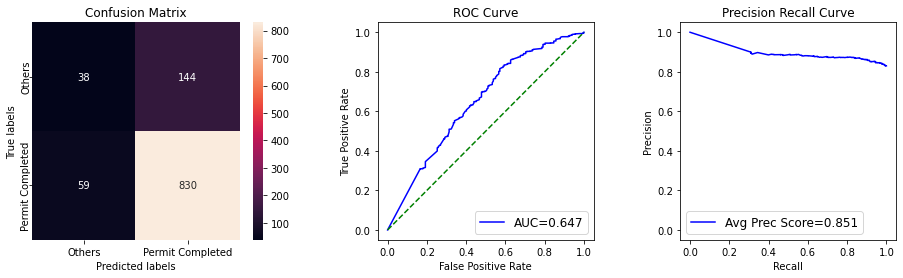

              precision    recall  f1-score   support

           0       0.39      0.21      0.27       182
           1       0.85      0.93      0.89       889

    accuracy                           0.81      1071
   macro avg       0.62      0.57      0.58      1071
weighted avg       0.77      0.81      0.79      1071



In [35]:
# define classification labels
clabels=['Others', 'Permit Completed']
    
plot_clf_metrics(y_test, y_pred1, y_proba1[:,1], clabels)
print(classification_report(y_test,y_pred1))

### 4.2. LogisticRegression Model

In [36]:
# instantiate logistic regression model
lm = LogisticRegression(class_weight='balanced', random_state=ranstate)  #['balanced',None] def is none)

# try hyperparameters obtained from GSCV
# lm = LogisticRegression(class_weight='balanced', penalty='l1', solver='saga', random_state=ranstate) 

# fit model with training ds
lm.fit(X_train, y_train)

# calc prediction and probability for positive label given an X
y_pred2 = lm.predict(X_test)
y_proba2 = lm.predict_proba(X_test)

# cross validate model with test dataset
lm.score(X_test, y_test)

0.5163398692810458

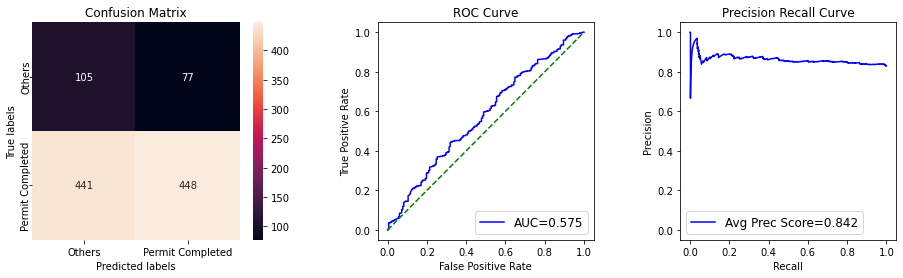

              precision    recall  f1-score   support

           0       0.19      0.58      0.29       182
           1       0.85      0.50      0.63       889

    accuracy                           0.52      1071
   macro avg       0.52      0.54      0.46      1071
weighted avg       0.74      0.52      0.58      1071



In [37]:
plot_clf_metrics(y_test, y_pred2, y_proba2[:,1], clabels)
print(classification_report(y_test,y_pred2))

### 4.3. GaussianProcessClassifier Model

In [38]:
# instantiate model
gpcm = GaussianProcessClassifier(random_state=ranstate)

# fit mod with training ds
gpcm.fit(X_train, y_train)

# calc predicted val and probability of predicting positive label given an X
y_pred3 = gpcm.predict(X_test)
y_proba3 = gpcm.predict_proba(X_test)

# crossvalidate with test ds
gpcm.score(X_test, y_test)  # equivalent to np.mean(y_pred == y_test) or accuracy(y_pred == y_test)

0.8281979458450047

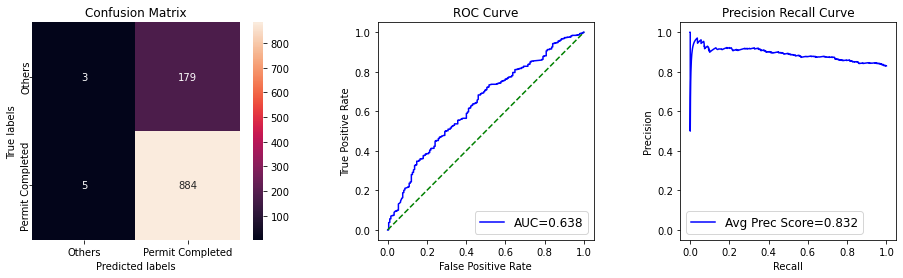

              precision    recall  f1-score   support

           0       0.38      0.02      0.03       182
           1       0.83      0.99      0.91       889

    accuracy                           0.83      1071
   macro avg       0.60      0.51      0.47      1071
weighted avg       0.75      0.83      0.76      1071



In [39]:
plot_clf_metrics(y_test, y_pred3, y_proba3[:,1], clabels)
print(classification_report(y_test,y_pred3))

### 4.4. GradientBoostingClassifier Model

In [40]:
# instantiate and fit training dataset
gbcm = GradientBoostingClassifier(n_estimators=100, random_state=ranstate)
gbcm.fit(X_train, y_train)

# calc predicted val and probability of predicting positive label given an X
y_pred4 = gbcm.predict(X_test)
y_proba4 = gbcm.predict_proba(X_test)

# crossvalidate with test ds
gbcm.score(X_test, y_test)  # equivalent to np.mean(y_pred == y_test) or accuracy(y_pred == y_test)
roc_auc_score(y_test,y_proba4[:,1])

0.6465438386135799

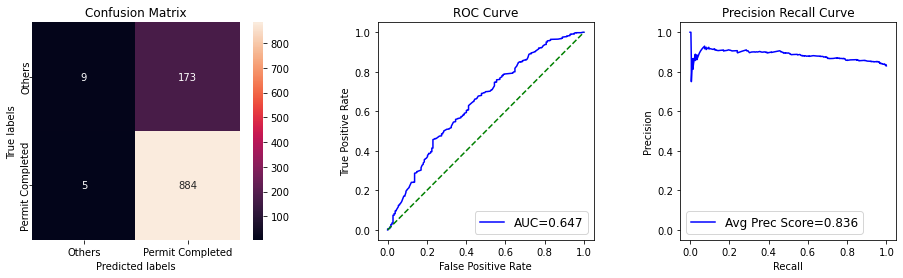

              precision    recall  f1-score   support

           0       0.64      0.05      0.09       182
           1       0.84      0.99      0.91       889

    accuracy                           0.83      1071
   macro avg       0.74      0.52      0.50      1071
weighted avg       0.80      0.83      0.77      1071



In [41]:
plot_clf_metrics(y_test, y_pred4, y_proba4[:,1], clabels)
print(classification_report(y_test,y_pred4))

### 4.5. XGBoost Model

In [42]:
# instantiate XGB model with optimized params
xgbm = XGBClassifier(random_state=ranstate)
    # max_depth=3, n_estimators=100, gamma=1, learning_rate=0.1

# fit xgbm with training dataset
xgbm.fit(X_train, y_train)

# calc predicted val and probability of predicting positive label given an X
y_pred5 = xgbm.predict(X_test)
y_proba5 = xgbm.predict_proba(X_test)

# crossvalidate with test ds
xgbm.score(X_test, y_test)  # equivalent to np.mean(y_pred == y_test) or accuracy(y_pred == y_test)

0.8300653594771242

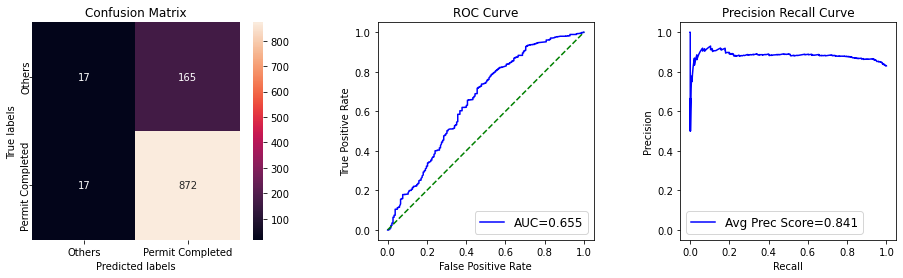

              precision    recall  f1-score   support

           0       0.50      0.09      0.16       182
           1       0.84      0.98      0.91       889

    accuracy                           0.83      1071
   macro avg       0.67      0.54      0.53      1071
weighted avg       0.78      0.83      0.78      1071



In [43]:
plot_clf_metrics(y_test, y_pred5, y_proba5[:,1], clabels)
print(classification_report(y_test,y_pred5))

### 4.6. SupportVectorClassifier Model

In [44]:
# instantiate and fit SVC model
svcm = SVC(gamma=0.01, C=1, kernel='rbf', random_state=ranstate, probability=True,  class_weight='balanced')  #['balanced','balanced_subsample',None] def is none)
svcm.fit(X_train, y_train)

# calc predicted val and probability of predicting positive label given an X
y_pred6 = svcm.predict(X_test)
y_proba6 = svcm.predict_proba(X_test)

# # crossvalidate with test ds
# svcm.score(X_test, y_test)  # equivalent to np.mean(y_pred == y_test) or accuracy(y_pred == y_test)

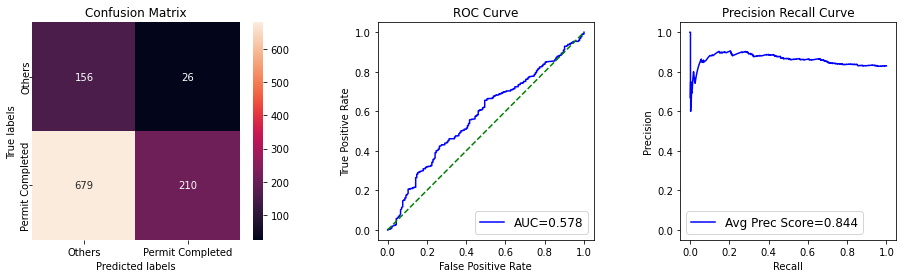

              precision    recall  f1-score   support

           0       0.19      0.86      0.31       182
           1       0.89      0.24      0.37       889

    accuracy                           0.34      1071
   macro avg       0.54      0.55      0.34      1071
weighted avg       0.77      0.34      0.36      1071



In [45]:
plot_clf_metrics(y_test, y_pred6, y_proba6[:,1], clabels)
print(classification_report(y_test,y_pred6))

### 4.7. SGDClassifier Model

In [46]:
# instantiate and fit SGD model
sgdm = SGDClassifier(alpha=0.01,loss='log_loss',random_state=ranstate,class_weight=None)  #['balanced','balanced_subsample',None] def is none
sgdm.fit(X_train, y_train)

# calc predicted val and probability of predicting positive label given an X
y_pred7 = sgdm.predict(X_test)
y_proba7 = sgdm.predict_proba(X_test)

# cross validate model with test dataset
sgdm.score(X_test, y_test)

0.830999066293184

In [47]:
average_precision_score(y_test, y_pred7)
roc_auc_score(y_test, y_pred7)

0.5093017219001471

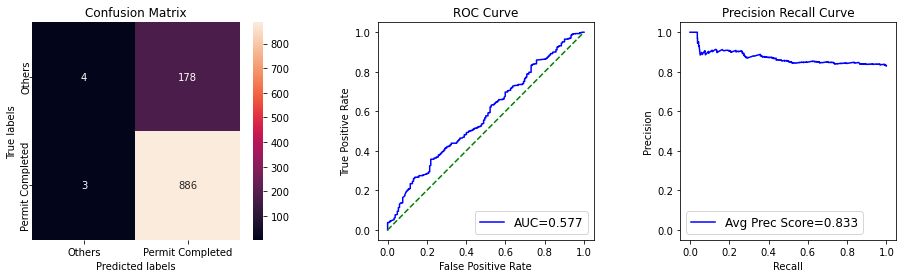

              precision    recall  f1-score   support

           0       0.57      0.02      0.04       182
           1       0.83      1.00      0.91       889

    accuracy                           0.83      1071
   macro avg       0.70      0.51      0.47      1071
weighted avg       0.79      0.83      0.76      1071



In [48]:
plot_clf_metrics(y_test, y_pred7, y_proba7[:,1], clabels)
print(classification_report(y_test,y_pred7))

## 4.8. GaussianNB

In [49]:
# instantiate model
gnbm = GaussianNB()

# fit mod with training ds
gnbm.fit(X_train, y_train)

# calc predicted val and probability of predicting positive label given an X
y_pred8 = gnbm.predict(X_test)
y_proba8 = gnbm.predict_proba(X_test)

# crossvalidate with test ds
gnbm.score(X_test, y_test)

0.3557422969187675

In [50]:
average_precision_score(y_test, y_pred8)
roc_auc_score(y_test, y_pred8)

0.5376395258285022

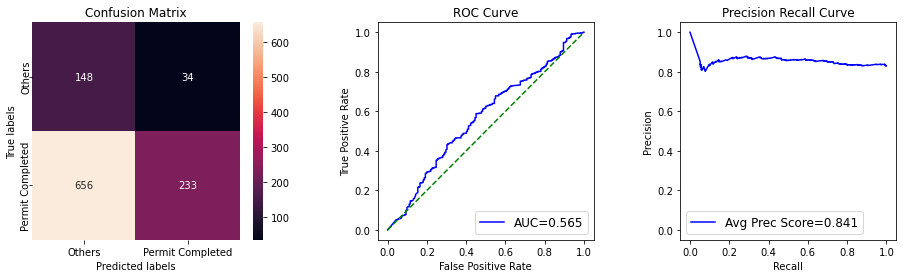

              precision    recall  f1-score   support

           0       0.18      0.81      0.30       182
           1       0.87      0.26      0.40       889

    accuracy                           0.36      1071
   macro avg       0.53      0.54      0.35      1071
weighted avg       0.76      0.36      0.39      1071



In [51]:
plot_clf_metrics(y_test, y_pred8, y_proba8[:,1], clabels)
print(classification_report(y_test,y_pred8))

## 4.9. KNNeighbbors Classifier

In [52]:
# instantiate initial model
knnm = KNeighborsClassifier() # default neighbors=5

# use optimized hyperparams from GSCV
# knnm = KNeighborsClassifier(algorithm='brute', n_neighbors=7, weights='distance')

# fit mod with training ds
knnm.fit(X_train, y_train)

# calc predicted val and probability of predicting positive label given an X
y_pred9 = knnm.predict(X_test)
y_proba9 = knnm.predict_proba(X_test)

# crossvalidate with test ds
knnm.score(X_test, y_test)

0.8328664799253035

In [53]:
average_precision_score(y_test, y_pred9)
roc_auc_score(y_test, y_pred9)

0.5584926884139483

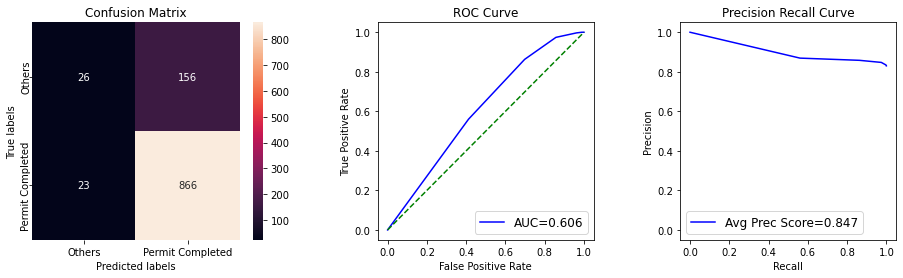

              precision    recall  f1-score   support

           0       0.53      0.14      0.23       182
           1       0.85      0.97      0.91       889

    accuracy                           0.83      1071
   macro avg       0.69      0.56      0.57      1071
weighted avg       0.79      0.83      0.79      1071



In [54]:
plot_clf_metrics(y_test, y_pred9, y_proba9[:,1], clabels)
print(classification_report(y_test,y_pred9))

## 4.10. BalancedRandomForestClassifier

In [55]:
from imblearn.ensemble import BalancedRandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

# instantiate default model
brfcm = BalancedRandomForestClassifier(random_state=ranstate)

# test with tuned hyperparams from GSCV
# brfcm = BalancedRandomForestClassifier(random_state=ranstate, criterion='entropy', 
#                                       max_features=6, n_estimators=500, class_weight='balanced')

# fit mod with training ds
brfcm.fit(X_train, y_train)

# calc predicted val and probability of predicting positive label given an X
y_pred10 = brfcm.predict(X_test)
y_proba10 = brfcm.predict_proba(X_test)

# crossvalidate with test ds
brfcm.score(X_test, y_test)

0.6097105508870215

In [56]:
average_precision_score(y_test, y_pred10)
roc_auc_score(y_test, y_pred10)

0.6010426581292724

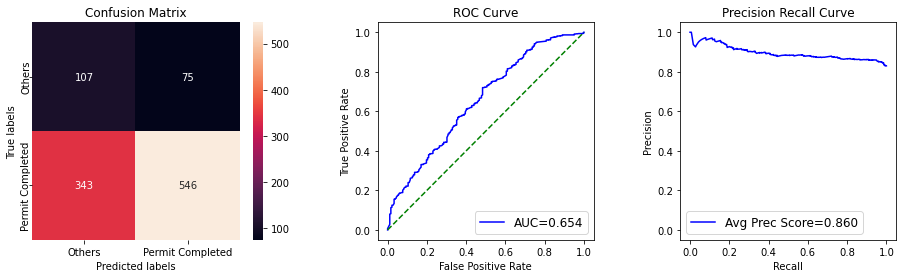

              precision    recall  f1-score   support

           0       0.24      0.59      0.34       182
           1       0.88      0.61      0.72       889

    accuracy                           0.61      1071
   macro avg       0.56      0.60      0.53      1071
weighted avg       0.77      0.61      0.66      1071



In [57]:
plot_clf_metrics(y_test, y_pred10, y_proba10[:,1], clabels)
print(classification_report(y_test,y_pred10))

## 5. Implement GridSearchCV for Hyperparameter Tuning of better performing models

In [58]:
# Select top 3 models and define search space for GridSearchCV tuning
# 0 - XGBoost
# 1 - RandomForest
# 2 - KNN
# 3 - LogReg
# 4 - BalancedRandomForest

search_space = {"0":{"n_estimators":[100,200,500],
                     "max_depth" :[3,6,9],
                     "gamma": [0.01,0,1],
                     "learning_rate": [0.001, 0.01, 0.1, 1] },
                
                "1":{"n_estimators":[100,200,500],
                     "max_features" :[3,6,9],
                     "criterion": ['gini','entropy','log_loss'],
                     "class_weight": ['None','balanced','balanced_subsampled'] },
                
                "2":{"n_neighbors":[3,7],
                     "weights" :['uniform','distance'],
                     "algorithm":['auto','ball_tree','kd_tree','brute'] },
                
                "3":{"penalty":['elasticnet','l1','l2'],
                     "solver":['saga'],
                     "class_weight":['None','balanced'] },
                
                "4":{"n_estimators":[100,200,500],
                     "max_features" :[3,6,9],
                     "criterion": ['gini','entropy','log_loss'],
                     "class_weight": ['None','balanced','balanced_subsampled'] }     
               }

In [62]:
from sklearn.model_selection import GridSearchCV
import multiprocessing

classifiers =[XGBClassifier(random_state=ranstate),
              RandomForestClassifier(random_state=ranstate),
              KNeighborsClassifier(),
              LogisticRegression(random_state=ranstate),
              BalancedRandomForestClassifier(random_state=ranstate)]

# change classifiers and search_space indices with the model number accordingly to tune selected model
GSobj = GridSearchCV(estimator = classifiers[0],
                    param_grid = search_space['0'],
                    scoring =['roc_auc','f1','average_precision'],
                    refit = 'roc_auc',
                    n_jobs=-1,
                    cv = 5, # find key-fold validation
                    verbose = 4)
# to choose other scorer options: sklearn.metrics.get_scorer_names()

# start tuning.....
GSobj.fit(X_train, y_train) 

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     num_parallel_tree=None, random_state=4321,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
             n_jobs=-1,
             param_grid={'gamma': [0.01, 0, 1],
                         'learning_rate': [0.001, 0.01, 0.1, 1],
                         'max_depth': [3, 6, 9],
                         'n_estimators': [100, 200, 500]},
             refit='roc_auc', scoring=['roc_auc', 'f1', 'average_precision'],
             verbose=4)

In [63]:
print(GSobj.best_score_)
print(GSobj.best_params_)

GSdf = pd.DataFrame(GSobj.cv_results_)
GSdf = GSdf.sort_values('rank_test_roc_auc')
GSdf.to_csv(path+'GScv_resultsXGB.csv')       # XGB  RFC  KNN  LR   BRFC 

0.6622476893795204
{'gamma': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


Observation from this exercise:
* Most models explored were able to predict true positive label well, but not as good for predicting true negative labels. Likely because of imbalanced dataset (~85% of dataset belongs to the true label); and predictors are not well-correlated to the target event. 

* Ensemble model achieved highest roc_auc score of ~0.64. 

# 5. References:
1. https://www.youtube.com/watch?v=BFaadIqWlAg&list=PPSV
2. https://data.seattle.gov/